## Autoencoder

An autoencoder is a neural network that is trained to perform the task of encoding and decoding an item, such that the output from this process is as close to the original item as possible.

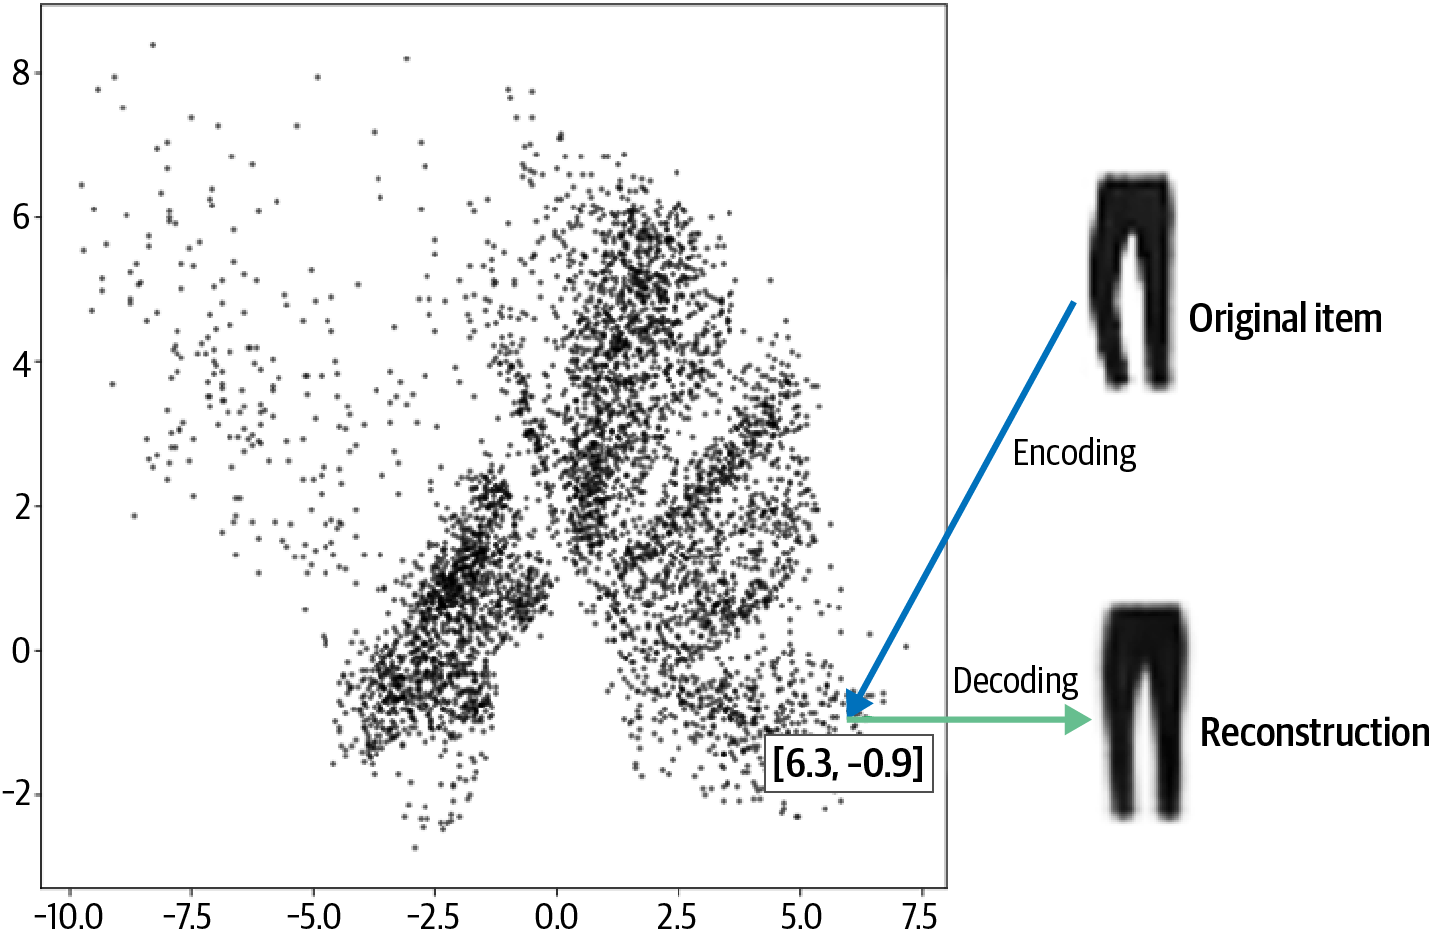

An autoencoder is a neural network made up of two parts : 

> An encoder network that compresses high-dimensional input data such as an image into a lower-dimensional embedding vector

> A decoder network that decompresses a given embedding vector back to the original domain (e.g., back to an image)

It is the **embedding space (latent space)** that is the interesting part of the autoencoder, as sampling from this space will allow us to generate new images.

The embedding (z) is a compression of the original image into a lower-dimensional latent space. 

Autoencoders can be used to clean noisy images, since the encoder learns that it is not useful to capture the position of the random noise inside the latent space in order to reconstruct the original.

When training an autoencoder on clean data, the model learns to represent the essential characteristics of the input in the latent space. However, when the autoencoder is exposed to noisy data during training, it tends to learn a representation that filters out the noise, as capturing noise is not necessary for accurately reconstructing the original input.

This ability to denoise arises because the autoencoder learns a compact representation that focuses on the essential information needed for reconstruction. If the noise in the input is random and doesn't contribute to the overall structure of the data, the autoencoder is likely to ignore it in the latent space.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from tensorflow.keras import datasets
(x_train,y_train), (x_test,y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


## Labels in FASHION MNIST Dataset

| ID | Clothing Label |
|----|-----------------|
| 0  | T-shirt/top     |
| 1  | Trouser         |
| 2  | Pullover        |
| 3  | Dress           |
| 4  | Coat            |
| 5  | Sandal          |
| 6  | Shirt           |
| 7  | Sneaker         |
| 8  | Bag             |
| 9  | Ankle boot      |


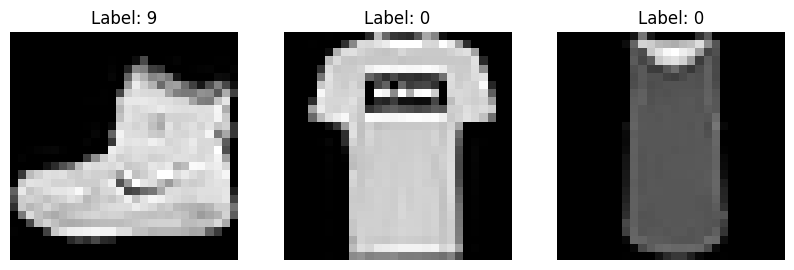

In [12]:
num_images_to_display = 3

plt.figure(figsize=(10, 4))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.show()

In [6]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

In [7]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [8]:
from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

In [16]:
# Encoder

encoder_input = layers.Input(
     shape=(32, 32, 1), name = "encoder_input"
)

x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (378.

In [17]:
# Decoder
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        1846

In [18]:
autoencoder =  models.Model(encoder_input, decoder(encoder_output))
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

Binary cross-entropy loss is asymmetrical — it penalizes errors toward the extremes more heavily than errors toward the center. For example, if the true pixel value is high (say 0.7), then generating a pixel with value 0.8 is penalized more heavily than generating a pixel with value 0.6. If the true pixel value is low (say 0.3), then generating a pixel with value 0.2 is penalized more heavily than generating a pixel with value 0.4.

For RMSE means that your generated output will be symmetrically distributed around the average pixel values (because an overestimation is penalized equivalently to an underestimation).

This has the effect of binary cross-entropy loss producing slightly blurrier images than RMSE loss (as it tends to push predictions toward 0.5), 

In [19]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=5,
    batch_size=100,
    shuffle=True,
    validation_data=(x_test, x_test),
)

Epoch 1/5
600/600 [==============================] - 109s 178ms/step - loss: 0.2903 - val_loss: 0.2610
Epoch 2/5
600/600 [==============================] - 106s 177ms/step - loss: 0.2576 - val_loss: 0.2569
Epoch 3/5
600/600 [==============================] - 106s 176ms/step - loss: 0.2544 - val_loss: 0.2552
Epoch 4/5
600/600 [==============================] - 105s 175ms/step - loss: 0.2523 - val_loss: 0.2527
Epoch 5/5
600/600 [==============================] - 106s 177ms/step - loss: 0.2508 - val_loss: 0.2517


In [86]:
example_images = x_test[:5000]
example_labels = y_test[:5000]
predictions = autoencoder.predict(example_images)

157/157 [==============================] - 3s 19ms/step


#### Reconstructing Images |  encoding and decoding items 

Example real clothing items


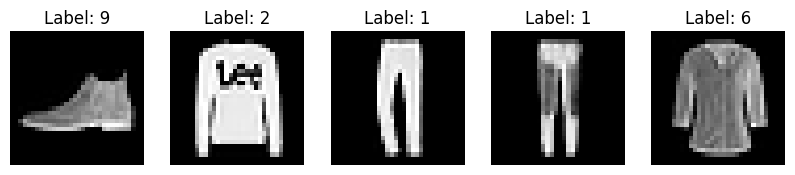

Embeddings
[[-1.6546086 -1.042184 ]]
[[ 2.78325   -4.5912967]]
[[5.5877895 2.6404598]]
[[3.3305168 1.9490101]]
[[ 1.0239996 -2.6614656]]

Reconstructions


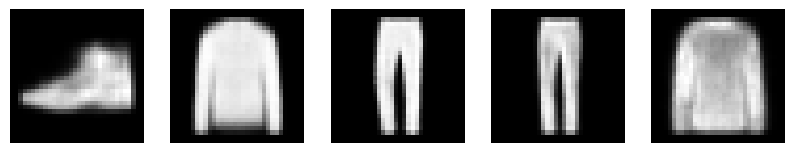

In [87]:
print("Example real clothing items")
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(example_images[i], cmap='gray')        
    plt.title(f"Label: {example_labels[i]}")
    plt.axis('off')        

plt.show()

print("Embeddings [The 2D vectors after encoding]")
for i in range(5):    
    input_image = np.expand_dims(example_images[i], axis=0)
    embeddings = encoder.predict(input_image,verbose=False)    
    print(embeddings)
print()
    
print("Reconstructions")


plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(predictions[i], cmap='gray')        
    plt.axis('off')
plt.show()    

### Visualizing the Latent Space | How images are embedded into the latent space by passing the test set through the encoder

157/157 [==============================] - 1s 4ms/step


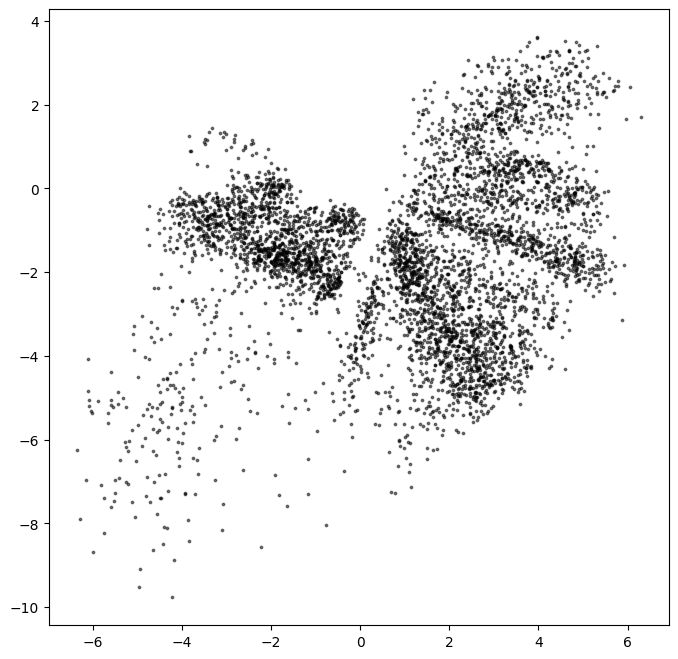

In [88]:
embeddings = encoder.predict(example_images)

plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

157/157 [==============================] - 1s 5ms/step
[[-1.6546087 -1.0421842]
 [ 2.7832506 -4.5912976]
 [ 5.587788   2.6404593]
 [ 3.3305175  1.9490095]
 [ 1.0239998 -2.6614654]
 [ 4.5654297  1.3282232]
 [ 1.1666342 -1.0962362]
 [ 1.156871  -2.0271327]
 [-2.8071496  1.2864684]
 [-3.5520642 -0.381901 ]]


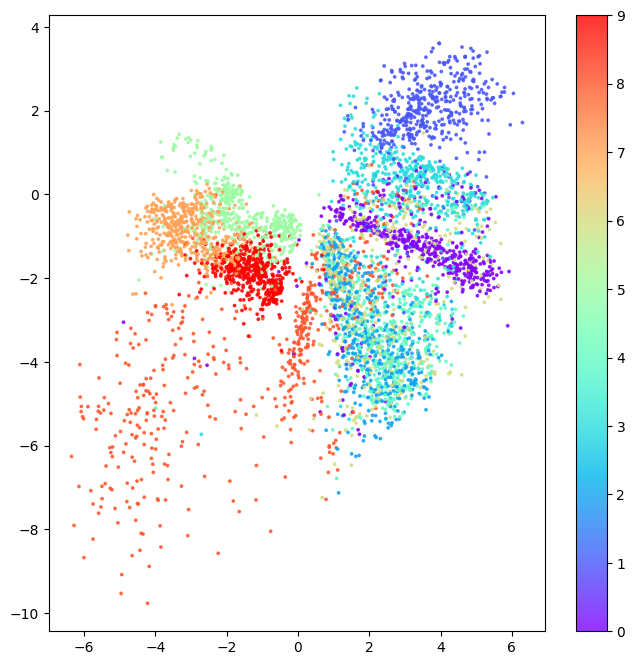

In [89]:
embeddings = encoder.predict(example_images)

# Some examples of the embeddings
print(embeddings[:10])

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

#### Generating New Images by sampling some points in the latent space and using the decoder

In [91]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, 2)
)

In [92]:
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 131ms/step


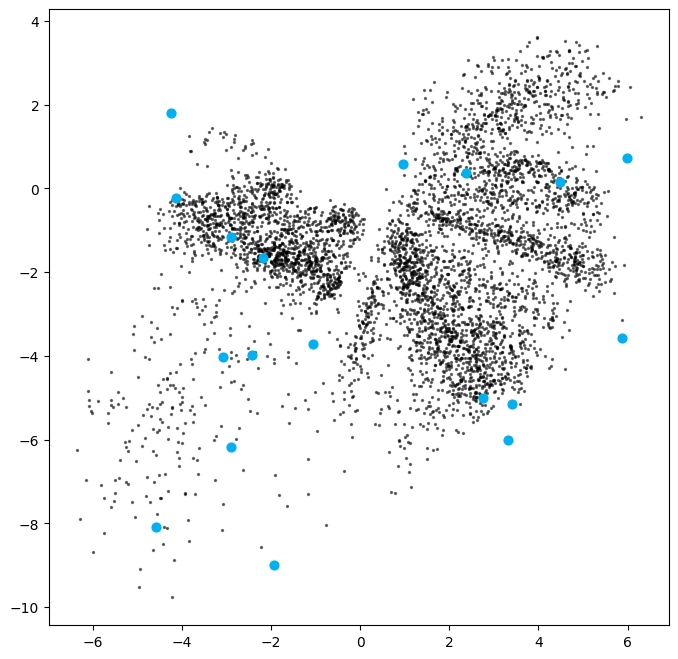

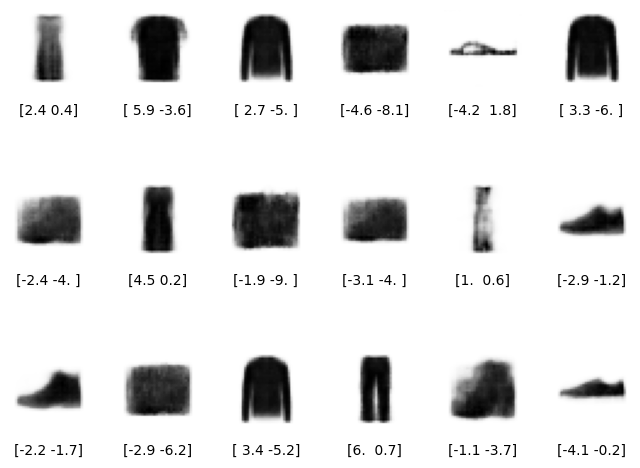

In [93]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 0s 17ms/step


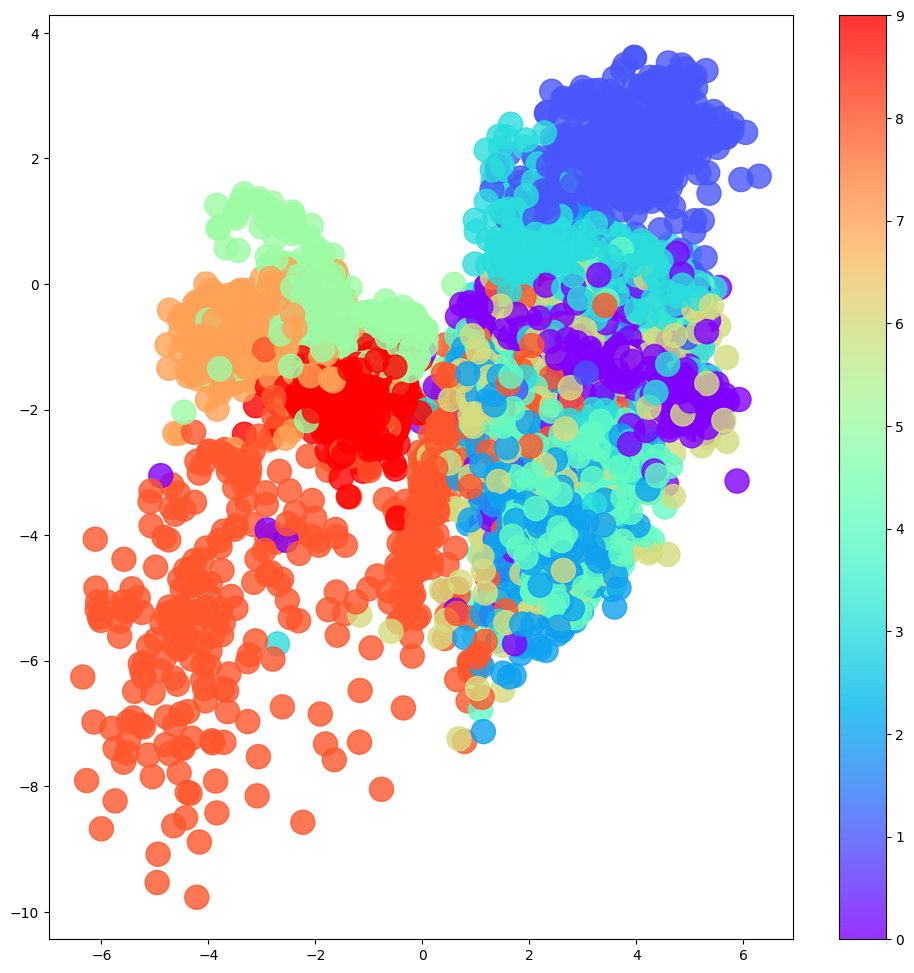

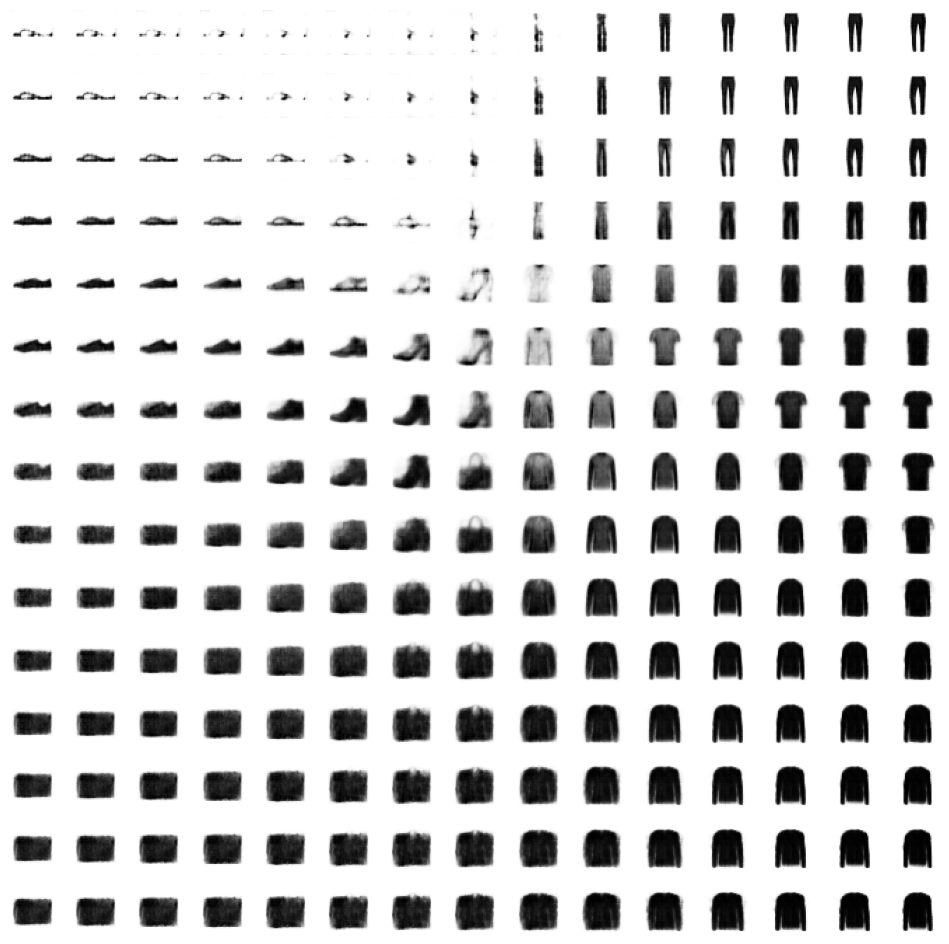

In [94]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

# Variational Autoencoders

In an autoencoder, each image is mapped directly to one point in the latent space. 

In a variational autoencoder, each image is instead mapped to a multivariate normal distribution around a point in the latent space

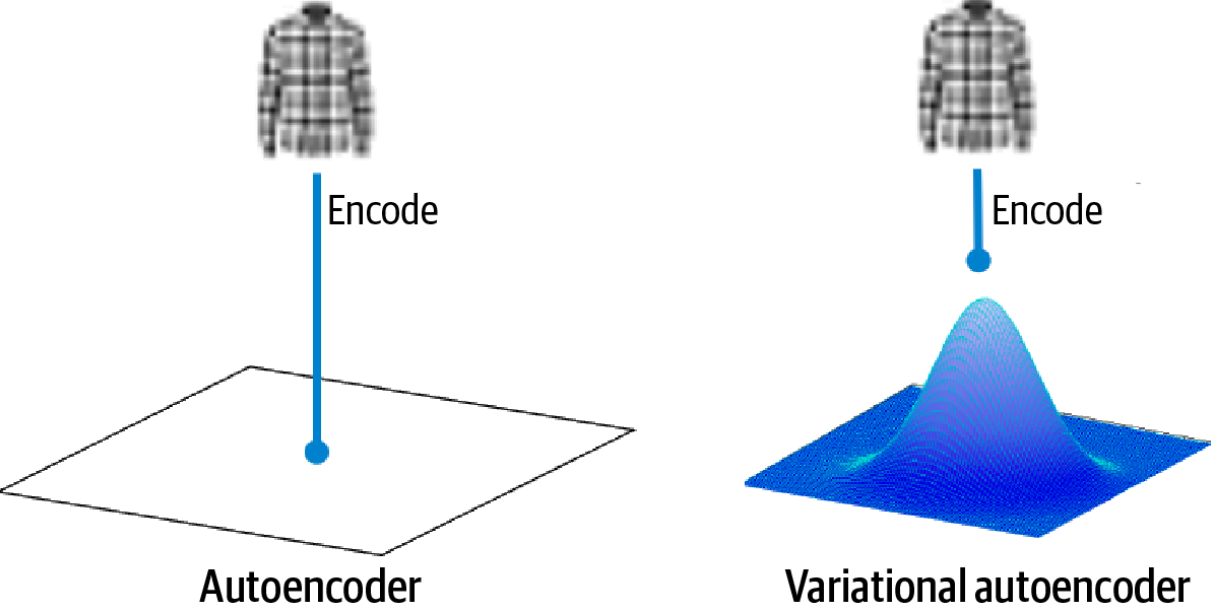

The probability density function (PDF) of the normal distribution in one dimension is given by the formula:

#          $f(x | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}$

Here:
- $x$ represents a random variable.
- $\mu$ is the mean of the distribution.
- $\sigma^2$ is the variance of the distribution.
- $\sigma$ is the standard deviation of the distribution.
- $e$ is the base of the natural logarithm, approximately equal to 2.71828.

This formula describes the shape of the normal distribution curve, which is symmetric and bell-shaped. The mean ($\mu$) determines the center of the distribution, and the standard deviation ($\sigma$) determines the spread or width of the distribution. The larger the standard deviation, the wider the distribution. The constant term $\frac{1}{\sqrt{2\pi\sigma^2}}$ ensures that the area under the curve integrates to 1, representing the total probability.

The formula for sampling a point $ z $ from a normal distribution with a specified mean $ \mu $ and standard deviation $ \sigma $. The equation is:

## $z = \mu + \sigma \cdot $ε

where $ ε $ is sampled from a standard normal distribution. In other words, $ ε $ is a random variable following a standard normal distribution with a mean of 0 and a standard deviation of 1. By scaling and shifting this standard normal variable, you can generate random samples from a normal distribution with the desired mean ($ \mu $) and standard deviation ($ \sigma $).


### Covariance matrix

Mathematically, the variance ($\sigma^2$) of a random variable is calculated as the average of the squared differences between each individual value and the mean of the variable. For a random variable $X$ with values $x_1, x_2, \ldots, x_n$ and mean $\mu$, the variance is given by:

$\sigma^2 = \frac{1}{n} \sum_{i=1}^{n} (x_i - \mu)^2$

In the context of a multivariate distribution, when you have multiple random variables (dimensions), each variable has its own variance. The variances of individual variables are represented along the diagonal of the covariance matrix.

For example, if you have a two-dimensional multivariate distribution with variables $X$ and $Y$, the covariance matrix might look like this:

$\Sigma = \begin{bmatrix} \text{Var}(X) & \text{Cov}(X, Y) \\ \text{Cov}(Y, X) & \text{Var}(Y) \end{bmatrix}$

Here:
- $\text{Var}(X)$ is the variance of variable $X$.
- $\text{Var}(Y)$ is the variance of variable $Y$.
- $\text{Cov}(X, Y)$ and $\text{Cov}(Y, X)$ are the covariances between variables $X$ and $Y$.


The covariance matrix is a mathematical concept that provides a way to understand the joint variability of two or more random variables. In the context of probability and statistics, the covariance matrix is often used to describe the relationships between different components of a multivariate distribution.

For a set of $n$ random variables $X_1, X_2, \ldots, X_n$, the covariance matrix $C$ is an $n \times n$ symmetric matrix where the entry in the $i$-th row and $j$-th column (denoted as $C_{ij}$) represents the covariance between $X_i$ and $X_j$.

The formula for the covariance between two random variables $X_i$ and $X_j$ is given by:

$\text{cov}(X_i, X_j) = E[(X_i - \mu_i)(X_j - \mu_j)]$

Here:
- $E$ denotes the expected value.
- $\mu_i$ and $\mu_j$ are the means of $X_i$ and $X_j$, respectively.

The covariance matrix $C$ is defined as follows:

$C = \begin{bmatrix} \text{cov}(X_1, X_1) & \text{cov}(X_1, X_2) & \ldots & \text{cov}(X_1, X_n) \\ \text{cov}(X_2, X_1) & \text{cov}(X_2, X_2) & \ldots & \text{cov}(X_2, X_n) \\ \vdots & \vdots & \ddots & \vdots \\ \text{cov}(X_n, X_1) & \text{cov}(X_n, X_2) & \ldots & \text{cov}(X_n, X_n) \end{bmatrix}$

Key properties of the covariance matrix:
1. The diagonal elements ($C_{ii}$) represent the variances of the individual random variables.
2. The off-diagonal elements ($C_{ij}$ for $i \neq j$) represent the covariances between different pairs of random variables.
3. The matrix is symmetric ($C_{ij} = C_{ji}$), reflecting the fact that $\text{cov}(X_i, X_j) = \text{cov}(X_j, X_i)$.

The variances along the diagonal represent the spread of values for each individual variable, while the off-diagonal elements represent the covariances (relationships) between pairs of variables. In this way, the covariance matrix provides a comprehensive description of the variability and relationships within a multivariate distribution.

The "variance of individual variables" refers to the measure of how much each individual variable in a set varies or deviates from its mean or average. In the context of a probability distribution or a dataset with multiple variables, the variance quantifies the spread or dispersion of values for each variable independently.


### Multivariate standard normal distribution

In a multivariate normal distribution, the joint distribution of the random variables is assumed to be normal (Gaussian), and it is fully characterized by the mean vector and the covariance matrix.

The probability density function (PDF) for a multivariate normal distribution, denoted as $ \mathcal{N}(\boldsymbol{\mu}, \Sigma) $, in $ n $ dimensions. Here, $ \boldsymbol{\mu} $ is the mean vector, and $ \Sigma $ is the symmetric covariance matrix 

The formula:

## $f(\mathbf{x}_1, \ldots, \mathbf{x}_n) = \exp\left(-\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu})^T \Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu})\right) \cdot \frac{1}{\sqrt{(2\pi)^n \cdot |\Sigma|}}$


- $ \mathbf{x} = [\mathbf{x}_1, \ldots, \mathbf{x}_n]^T $ is the vector of random variables.
- $ \boldsymbol{\mu} = [\mu_1, \ldots, \mu_n]^T $ is the mean vector.
- $ \Sigma $ is the covariance matrix.
- $ |\Sigma| $ is the determinant of the covariance matrix.

An isotropic multivariate normal distributions, is where the covariance matrix is diagonal. This implies that the distribution is independent in each dimension, allowing for sampling a vector where each element is normally distributed with an independent mean and variance. The covariance matrix $ \Sigma $ in this case is represented as a diagonal matrix.

When the covariance matrix is diagonal, it means that the off-diagonal elements of the matrix are all zero. In other words, there is no covariance (linear relationship) between different pairs of variables, and each variable is only correlated with itself.

For a covariance matrix $\Sigma$ with variables $X_1, X_2, \ldots, X_n$, the diagonal elements $\Sigma_{ii}$ represent the variances of the individual variables, and the off-diagonal elements $\Sigma_{ij}$ (where $i \neq j$) represent the covariances between pairs of variables.

If the covariance matrix is diagonal, it can be represented as follows:

\$ \Sigma = \begin{bmatrix} \text{Var}(X_1) & 0 & \ldots & 0 \\ 0 & \text{Var}(X_2) & \ldots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \ldots & \text{Var}(X_n) \end{bmatrix} \$

Here:
- $\text{Var}(X_i)$ represents the variance of the $i$-th variable.
- $\Sigma_{ii}$ corresponds to the diagonal elements.
- $\Sigma_{ij} = 0$ for $i \neq j$ (off-diagonal elements).

Having a diagonal covariance matrix simplifies the modeling and analysis of multivariate data because it indicates that the variables are uncorrelated with each other. Each variable can be considered independently, and the joint distribution simplifies into a product of independent univariate distributions. 

A multivariate standard normal distribution $ \mathcal{N}(0, \mathbf{I}) $, where $ \mathbf{I} $ is the identity matrix is a multivariate distribution with the mean vector is zero, and the covariance matrix is the identity matrix. 



### VAEs

In the context of variational autoencoders (VAEs), the use of isotropic multivariate normal distributions simplifies the modeling and facilitates the training process.

Variational autoencoders assume that there is no correlation between dimensions in the latent space.

The encoder only needs to map each input to a mean vector and a variance vector and does not need to worry about covariance between dimensions.

Variance values are always positive, so we actually choose to map to the logarithm of the variance, as this can take any real number in the range (-∞, ∞). This way we can use a neural network as the encoder to perform the mapping from the input image to the mean and log variance vectors.

#### encoder

The encoder will take each input image and encode it to two vectors that together define a multivariate normal distribution in the latent space.

z_mean

    The mean point of the distribution

z_log_var

    The logarithm of the variance of each dimension
    

**Sampling Equation:**
   - To sample a point $z$ from the distribution defined by $z_{\text{mean}}$ and $z_{\text{log_var}}$, the following equation is used:
   
###           $ z = z_{\text{mean}} + z_{\text{sigma}} \cdot \epsilon \$
     
####   where $z_{\text{sigma}} = \exp(z_{\text{log_var}} \cdot 0.5)$ and $\epsilon \sim \mathcal{N}(0, I)$.

   **z_sigma ($ \sigma $) :**
   
   $z_{\text{sigma}}$ is the standard deviation of the distribution. It is calculated by taking the exponential of half of the logarithm of the variance ($z_{\text{log_var}}$).
   
   The use of the exponential function ensures that $z_{\text{sigma}}$ is always positive.
   
   #### $ \sigma = exp(log(\sigma)) = exp(2 * log(\sigma)/2) = exp(log(\sigma^2)/2) = \exp(z_{\text{log_var}} \cdot 0.5) $
   
   **epsilon ~ N(0, I):**   
   
$\epsilon$ is a vector of random variables sampled from a multivariate standard normal distribution ($\mathcal{N}(0, I)$). This means that each element of $\epsilon$ is drawn independently from a standard normal distribution with mean 0 and variance 1.

   The process of sampling is a key component in training VAEs. It introduces a stochastic element that encourages the latent space to be continuously distributed and aids in generating diverse and realistic samples during the generative process.

In summary, during the training of a VAE, the sampling equation combines the mean ($z_{\text{mean}}$), the standard deviation ($z_{\text{sigma}}$), and a random noise vector ($\epsilon$) to generate points in the latent space. This process allows the VAE to learn a continuous and smooth latent representation of the input data.
    

 #### VAE architecture diagram
 
 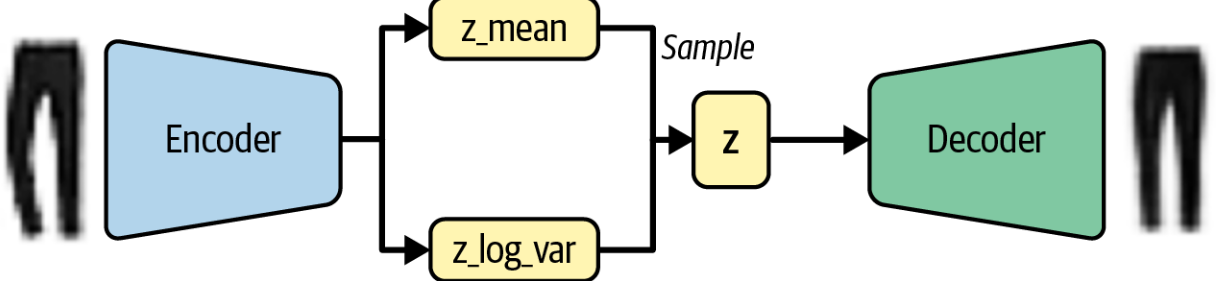
 
In a plain autoencoder there was no requirement for the latent space to be continuous, So even if the point $ (–2, 2) $ decodes to a well-formed image of a sandal, there’s no requirement for (–2.1, 2.1) to look similar.
 
Now, since we are sampling a random point from an area around $ z_{\text{mean}} $, the decoder must ensure that all points in the same neighborhood produce very similar images when decoded, so that the reconstruction loss remains small

Hence when we choose a point in the latent space that has never been seen by the decoder, it is likely to decode to an image that is well formed.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

In [9]:
# create a new layer by subclassing the Keras base Layer class
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
# By keeping all of the randomness of the layer contained within the variable epsilon, 
# the partial derivative of the layer output with respect to its input can be shown to be deterministic 
# (i.e., independent of the random epsilon), which is essential for backpropagation through the layer to be possible.    

In [10]:
# Encoder
encoder_input = layers.Input(
    shape=(32, 32, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(2, name="z_mean")(x) 
z_log_var = layers.Dense(2, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var]) 

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder") 

In [11]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

In [12]:
# Decoder
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        18464 

### The Loss Function

Kullback–Leibler (KL) divergence 

KL divergence is a way of measuring how much one probability distribution differs from another. 

In a VAE, we want to measure how much *our normal distribution* with parameters z_mean and z_log_var differs from a *standard normal distribution*

#### $ kl\_loss = -0.5 * sum(1 + z\_\log\_var - (z\_mean) ^ 2 - exp(z\_\log\_var)) $

The KL divergence term penalizes the network for encoding observations to z_mean and z_log_var variables that differ significantly from the parameters of a standard normal distribution, namely z_mean = 0 and z_log_var = 0

     We now have a well-defined distribution that we can use for choosing points in the latent space — the standard normal distribution

     This term tries to force all encoded distributions toward the standard normal distribution, there is less chance that large gaps will form between point clusters

     The encoder will try to use the space around the origin symmetrically and efficiently. The encoder is now stochastic, rather than deterministic.

In [13]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs): 
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data): 
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                500
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            ) 
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis = 1,
                )
            )
            total_loss = reconstruction_loss + kl_loss 

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(
    x_train,
    epochs=5,
    batch_size=100
)

Epoch 1/5
600/600 [==============================] - 89s 146ms/step - total_loss: 154.2748 - reconstruction_loss: 149.8524 - kl_loss: 4.4224
Epoch 2/5
600/600 [==============================] - 89s 149ms/step - total_loss: 134.6612 - reconstruction_loss: 129.6606 - kl_loss: 5.0005
Epoch 3/5
600/600 [==============================] - 89s 148ms/step - total_loss: 133.0303 - reconstruction_loss: 127.9438 - kl_loss: 5.0863
Epoch 4/5
600/600 [==============================] - 88s 147ms/step - total_loss: 132.1538 - reconstruction_loss: 127.0021 - kl_loss: 5.1517
Epoch 5/5
600/600 [==============================] - 89s 149ms/step - total_loss: 131.6357 - reconstruction_loss: 126.4340 - kl_loss: 5.2017


In [14]:
# Save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

##### Reconstruct using the variational autoencoder

In [32]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [16]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)

157/157 [==============================] - 3s 17ms/step


Example real clothing items


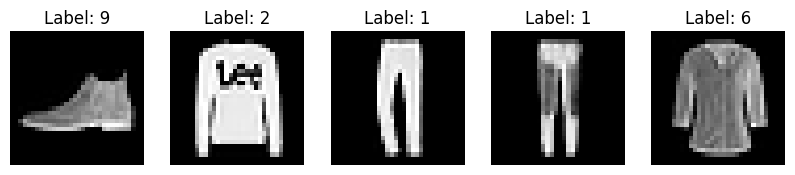

Embeddings [The 2D vectors after encoding]
[[-0.84935594 -1.275148  ]]
[[ 1.0982018  -0.05772221]]
[[1.069385 2.918055]]
[[-0.4193046  2.3782616]]
[[ 0.09721762 -0.0229128 ]]

Reconstructions


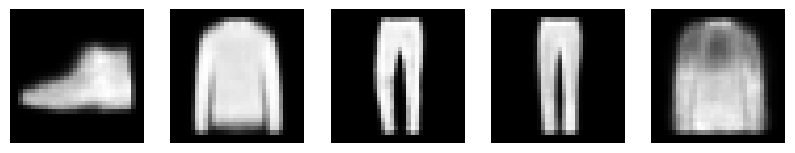

In [17]:
print("Example real clothing items")
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(example_images[i], cmap='gray')        
    plt.title(f"Label: {example_labels[i]}")
    plt.axis('off')        

plt.show()

print("Embeddings [The 2D vectors after encoding]")
for i in range(5):    
    input_image = np.expand_dims(example_images[i], axis=0)
    z_mean, z_var, z = encoder.predict(input_image,verbose=False)    
    print(z)
print()
    
print("Reconstructions")


plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(reconstructions[i], cmap='gray')        
    plt.axis('off')
plt.show()    

In [18]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [19]:
z_sample

array([[-0.23003489, -1.18895259],
       [ 1.13523951, -1.08779902],
       [-0.40723741, -0.15716897],
       [ 2.08405919, -1.29794666],
       [ 0.82736652, -0.61763512],
       [-0.15426822,  1.67614118],
       [-0.52040889, -0.16355003],
       [ 0.98539481, -0.77795711],
       [-0.34846049, -0.13162712],
       [ 1.12496523, -0.16984317],
       [ 1.10910079, -0.57358296],
       [-0.47199708,  0.32900014],
       [-0.53809612,  1.06505149],
       [ 2.31632753,  0.81551088],
       [-0.97523106,  0.11599298],
       [ 0.49377004, -1.36923403],
       [ 1.50255031, -1.20912022],
       [ 1.14171746, -0.77200634]])

In [20]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 133ms/step


In [36]:
z_mean, z_var, z = encoder.predict(example_images)

# Convert original embeddings and sampled embeddings to p-values
from scipy.stats import norm

p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

157/157 [==============================] - 1s 3ms/step


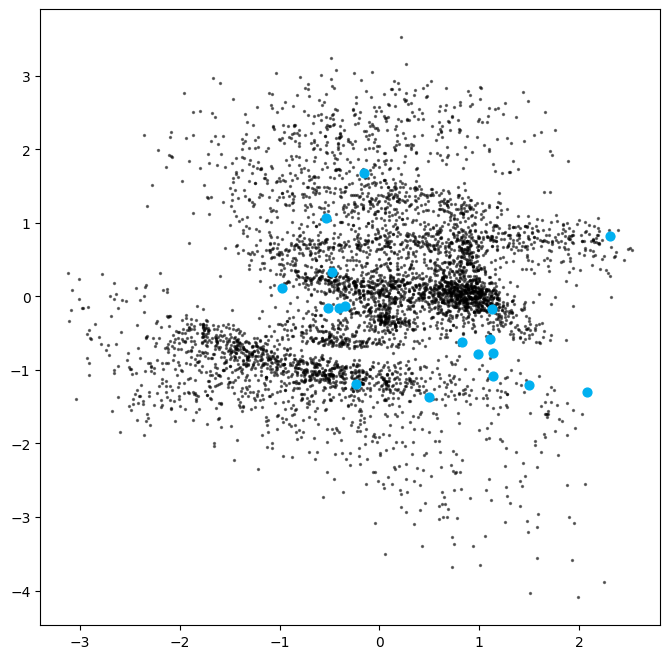

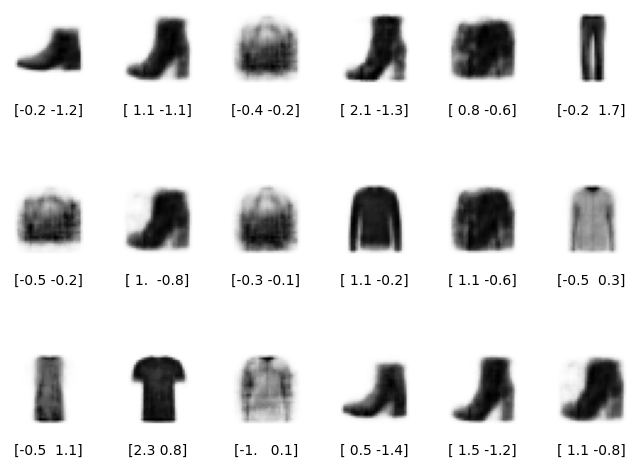

In [37]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

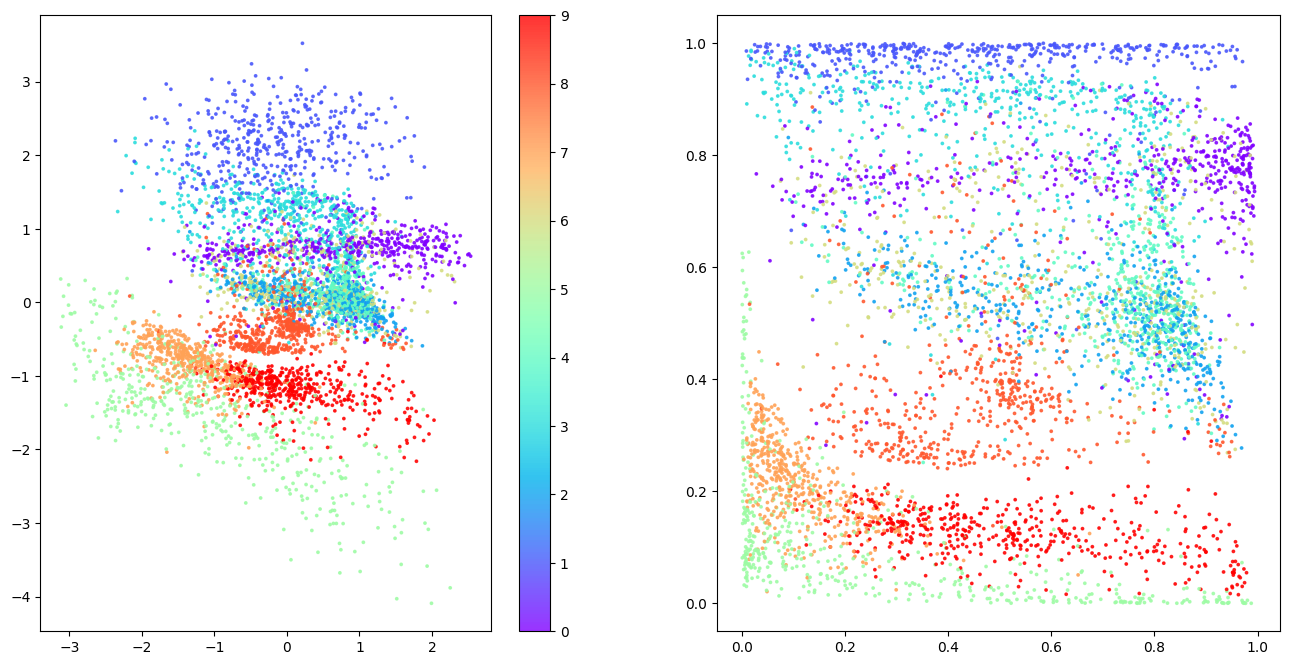

In [38]:
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

8/8 [==============================] - 0s 14ms/step


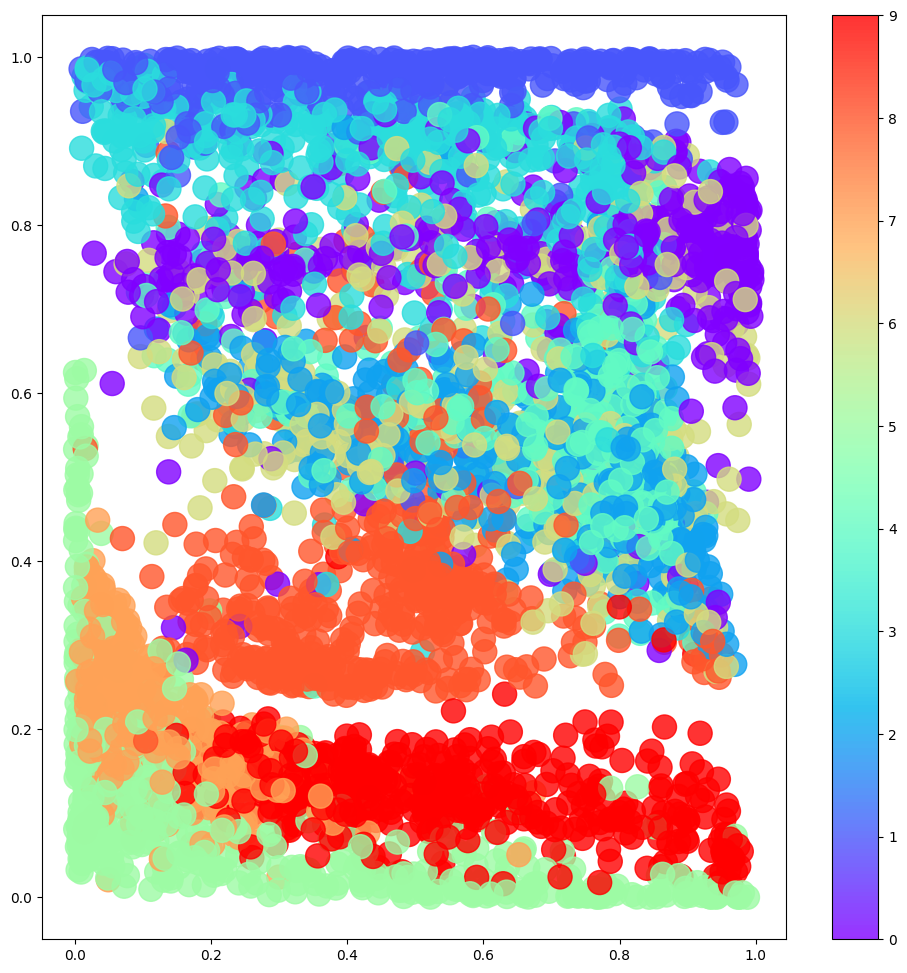

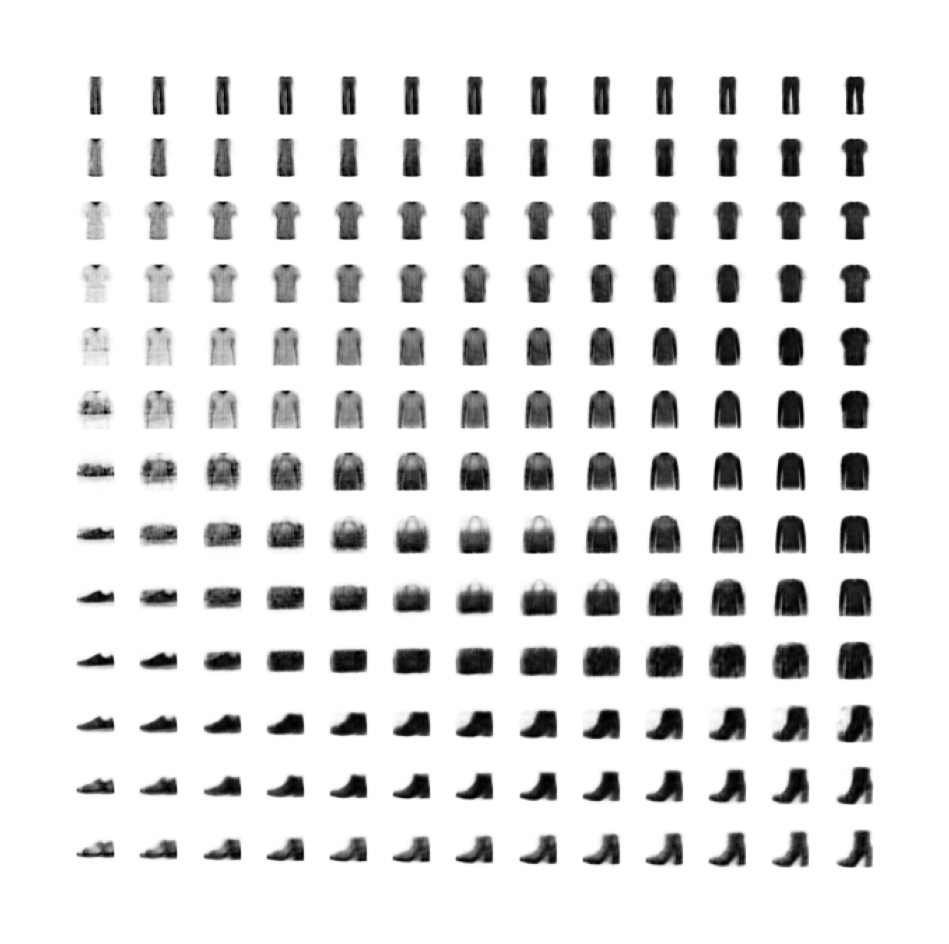

In [39]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")